In [ ]:
import pandas as pd
import ast

# Load the dataset
disease_df = pd.read_csv("./disease_features.csv")

# Display the first few rows
print("Original Data Preview:")
print(disease_df.head())

# Columns to parse
list_columns = ['Risk Factors', 'Symptoms', 'Signs']

# Convert stringified lists into Python lists and join as single strings
for col in list_columns:
    disease_df[col] = disease_df[col].apply(lambda x: " ".join(ast.literal_eval(x)))

# Show parsed result
print("\nParsed and Combined Text Preview:")
print(disease_df[list_columns].head())




Original Data Preview:
                   Disease                                       Risk Factors  \
0  Acute Coronary Syndrome  ['Hyperlipidemia', 'hypertension', 'smoking', ...   
1    Adrenal Insufficiency  ['Autoimmune diseases', 'Genetic predispositio...   
2                Alzheimer  ['Age', 'genetic factors', 'gender', 'cardiova...   
3        Aortic Dissection  ['Hypertension', 'Atherosclerosis', 'Family hi...   
4                   Asthma  ['Allergies', 'family history of asthma or all...   

                                            Symptoms  \
0  ['Chest pain', 'sweating', 'nausea', 'vomiting...   
1  ['Fatigue', 'Muscle weakness', 'Weight loss', ...   
2  ['Cognitive decline, including memory loss and...   
3  ['Intense chest or upper back pain', 'Sudden s...   
4  ['Recurrent episodes of wheezing', 'breathless...   

                                               Signs  \
0                                                 []   
1  ['Hyperpigmentation (especially in cre

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize TF-IDF vectorizers
tfidf_risk = TfidfVectorizer()
tfidf_symptoms = TfidfVectorizer()
tfidf_signs = TfidfVectorizer()

# Apply vectorizers
X_risk = tfidf_risk.fit_transform(disease_df['Risk Factors'])
X_symptoms = tfidf_symptoms.fit_transform(disease_df['Symptoms'])
X_signs = tfidf_signs.fit_transform(disease_df['Signs'])

# Print shapes and sample features
print("TF-IDF Shapes:")
print(f"Risk Factors: {X_risk.shape}")
print(f"Symptoms: {X_symptoms.shape}")
print(f"Signs: {X_signs.shape}")

print("\nSample Features from 'Symptoms':")
print(tfidf_symptoms.get_feature_names_out()[:10])


TF-IDF Shapes:
Risk Factors: (25, 360)
Symptoms: (25, 424)
Signs: (25, 236)

Sample Features from 'Symptoms':
['40' '65' '90' 'abdominal' 'ability' 'abnormal' 'abnormalities' 'absence'
 'accompanied' 'aches']


In [5]:
from scipy.sparse import hstack

# Combine the three TF-IDF matrices into a single feature matrix
X_tfidf_combined = hstack([X_risk, X_symptoms, X_signs])

print("Combined TF-IDF Matrix Shape:", X_tfidf_combined.shape)


Combined TF-IDF Matrix Shape: (25, 1020)


In [7]:
import numpy as np
from scipy import sparse

# Load the one-hot encoded matrix
one_hot_df = pd.read_csv("./encoded_output2.csv")

# Ensure all data in the dataframe is numeric
one_hot_df = one_hot_df.apply(pd.to_numeric, errors='coerce').fillna(0)

# Convert to sparse matrix for fair comparison
X_one_hot = sparse.csr_matrix(one_hot_df.values)

# Compare matrix shapes
print("Matrix Shapes:")
print(f"TF-IDF Combined: {X_tfidf_combined.shape}")
print(f"One-Hot Encoded: {X_one_hot.shape}")

# Compare sparsity (% of zero values)
def calculate_sparsity(matrix):
    if isinstance(matrix, np.ndarray):
        total_elements = matrix.size
        nonzero_elements = np.count_nonzero(matrix)
    else:  # For sparse matrix
        total_elements = matrix.shape[0] * matrix.shape[1]
        nonzero_elements = matrix.nnz
    return 100 * (1 - (nonzero_elements / total_elements))

tfidf_sparsity = calculate_sparsity(X_tfidf_combined)
onehot_sparsity = calculate_sparsity(X_one_hot)

print("\nSparsity Comparison (% of Zeros):")
print(f"TF-IDF: {tfidf_sparsity:.2f}%")
print(f"One-Hot: {onehot_sparsity:.2f}%")

# Number of unique features
print("\nUnique Feature Counts:")
print(f"TF-IDF: {X_tfidf_combined.shape[1]}")
print(f"One-Hot: {X_one_hot.shape[1]}")


Matrix Shapes:
TF-IDF Combined: (25, 1020)
One-Hot Encoded: (25, 497)

Sparsity Comparison (% of Zeros):
TF-IDF: 92.96%
One-Hot: 95.35%

Unique Feature Counts:
TF-IDF: 1020
One-Hot: 497


In [8]:
from sklearn.decomposition import PCA, TruncatedSVD

# Reduce to 2D and 3D using PCA
pca_tfidf_2d = PCA(n_components=2).fit(X_tfidf_combined.toarray())
pca_onehot_2d = PCA(n_components=2).fit(X_one_hot.toarray())

pca_tfidf_3d = PCA(n_components=3).fit(X_tfidf_combined.toarray())
pca_onehot_3d = PCA(n_components=3).fit(X_one_hot.toarray())

# Reduce to 2D using TruncatedSVD (works with sparse matrices directly)
svd_tfidf_2d = TruncatedSVD(n_components=2).fit(X_tfidf_combined)
svd_onehot_2d = TruncatedSVD(n_components=2).fit(X_one_hot)

# Explained variance ratio from PCA
explained_variance = {
    "PCA (TF-IDF, 2D)": pca_tfidf_2d.explained_variance_ratio_,
    "PCA (One-Hot, 2D)": pca_onehot_2d.explained_variance_ratio_,
    "PCA (TF-IDF, 3D)": pca_tfidf_3d.explained_variance_ratio_,
    "PCA (One-Hot, 3D)": pca_onehot_3d.explained_variance_ratio_,
}

explained_variance


{'PCA (TF-IDF, 2D)': array([0.06583976, 0.05894438]),
 'PCA (One-Hot, 2D)': array([0.10538866, 0.09170854]),
 'PCA (TF-IDF, 3D)': array([0.06571599, 0.05852169, 0.05686028]),
 'PCA (One-Hot, 3D)': array([0.10538866, 0.09170854, 0.06776557])}

In [11]:
# Create a basic mapping of diseases to high-level categories
disease_to_category = {
    "Acute Coronary Syndrome": "Cardiovascular",
    "Aortic Dissection": "Cardiovascular",
    "Atrial Fibrillation": "Cardiovascular",
    "Heart Failure": "Cardiovascular",
    "Hypertensive Emergency": "Cardiovascular",
    "Myocardial Infarction": "Cardiovascular",
    "Asthma": "Respiratory",
    "COPD": "Respiratory",
    "Pneumonia": "Respiratory",
    "Alzheimer": "Neurological",
    "Migraine": "Neurological",
    "Seizure": "Neurological",
    "Stroke": "Neurological",
    "Hypoglycemia": "Metabolic",
    "Type I Diabetes": "Metabolic",
    "Type II Diabetes": "Metabolic",
    "Hyperthyroidism": "Endocrine",
    "Hypothyroidism": "Endocrine",
    "Adrenal Insufficiency": "Endocrine",
    "Appendicitis": "Gastrointestinal",
    "Gastritis": "Gastrointestinal",
    "Peptic Ulcer": "Gastrointestinal"
}

# Map disease names to categories
disease_df["Category"] = disease_df["Disease"].map(disease_to_category).fillna("Other")

# Show counts per category
disease_df["Category"].value_counts()


Category
Other               13
Cardiovascular       4
Neurological         3
Respiratory          3
Endocrine            1
Gastrointestinal     1
Name: count, dtype: int64

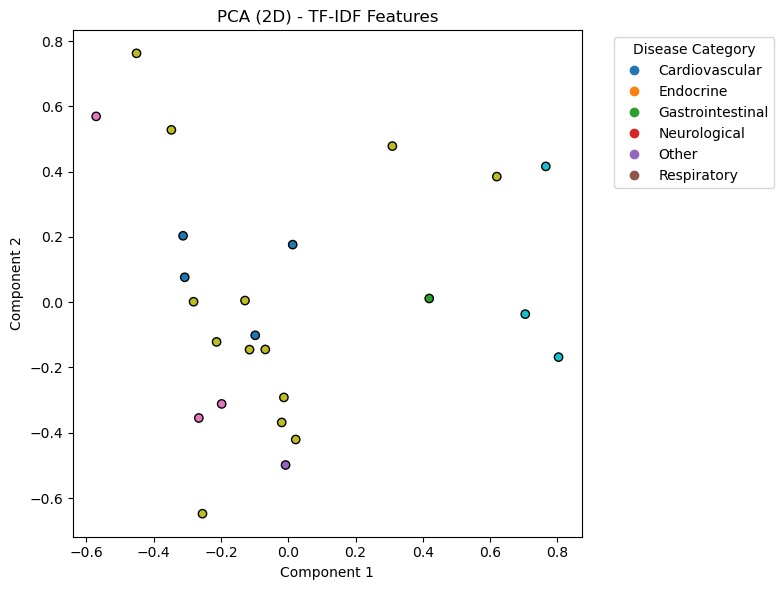

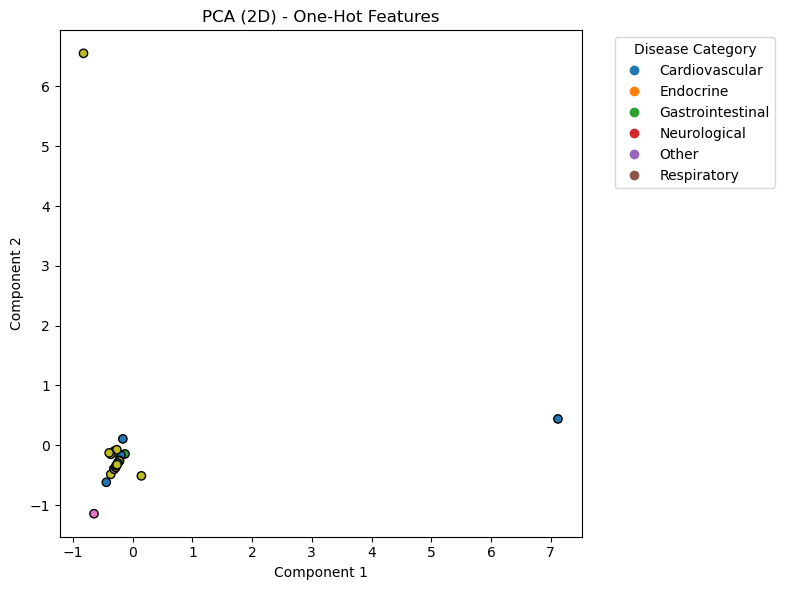

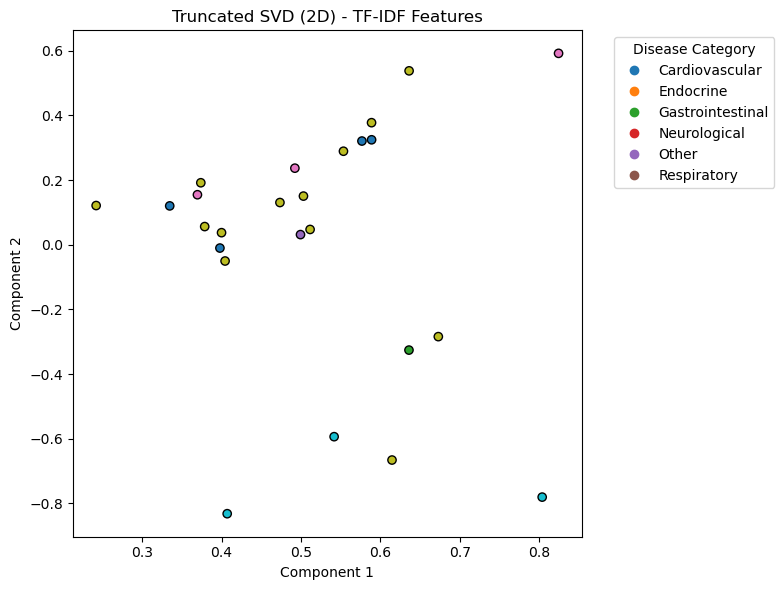

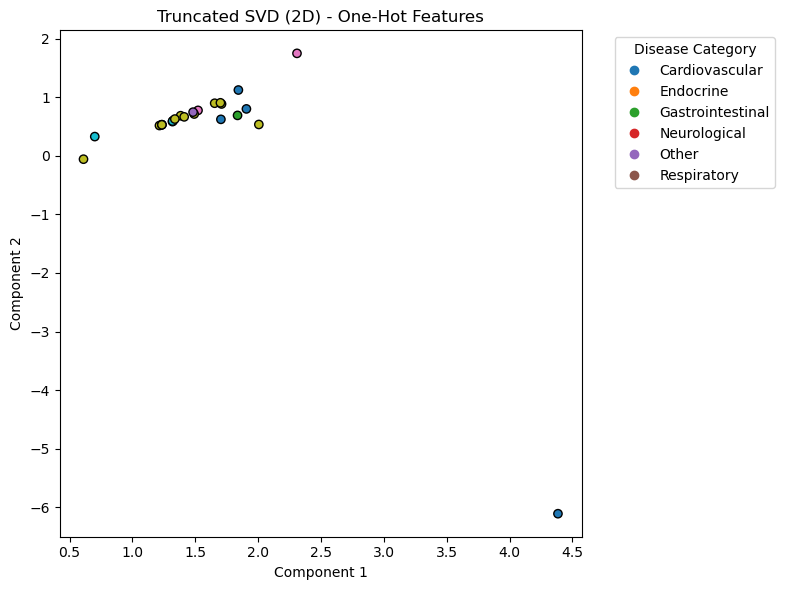

In [12]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA, TruncatedSVD

# Generate reduced dimensions
tfidf_pca_2d = pca_tfidf_2d.transform(X_tfidf_combined.toarray())
onehot_pca_2d = pca_onehot_2d.transform(X_one_hot.toarray())
tfidf_svd_2d = svd_tfidf_2d.transform(X_tfidf_combined)
onehot_svd_2d = svd_onehot_2d.transform(X_one_hot)

# Prepare category labels for coloring
labels = disease_df['Category']
unique_labels = sorted(labels.unique())
color_map = {label: idx for idx, label in enumerate(unique_labels)}
colors = [color_map[label] for label in labels]

# Plotting function
def plot_2d_scatter(data, title):
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(data[:, 0], data[:, 1], c=colors, cmap='tab10', edgecolor='k')
    plt.title(title)
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")

    # Legend
    handles = [plt.Line2D([], [], marker='o', linestyle='', label=label,
                          color=plt.cm.tab10(color_map[label] / 10)) for label in unique_labels]
    plt.legend(handles=handles, title="Disease Category", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

# Generate scatter plots
plot_2d_scatter(tfidf_pca_2d, "PCA (2D) - TF-IDF Features")
plot_2d_scatter(onehot_pca_2d, "PCA (2D) - One-Hot Features")
plot_2d_scatter(tfidf_svd_2d, "Truncated SVD (2D) - TF-IDF Features")
plot_2d_scatter(onehot_svd_2d, "Truncated SVD (2D) - One-Hot Features")


In [14]:
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
import numpy as np

# Encode target labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(disease_df['Category'])

# Distance metrics
distance_metrics = {
    "euclidean": "euclidean",
    "manhattan": "manhattan",
    "cosine": "cosine"
}

# Evaluation metrics
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, average='macro'),
    'recall': make_scorer(recall_score, average='macro'),
    'f1': make_scorer(f1_score, average='macro')
}

# Storage for results
results = []

# Run KNN on both TF-IDF and One-Hot
for name, X in [("TF-IDF", X_tfidf_combined), ("One-Hot", X_one_hot)]:
    for metric_name, metric in distance_metrics.items():
        for k in [3, 5, 7]:
            # Use a pipeline to normalize features (important for distance-based models)
            model = make_pipeline(Normalizer(), KNeighborsClassifier(n_neighbors=k, metric=metric))
            scores = cross_validate(model, X, y, cv=5, scoring=scoring)

            # Save results
            results.append({
                "Encoding": name,
                "Distance Metric": metric_name,
                "k": k,
                "Accuracy": np.mean(scores['test_accuracy']),
                "Precision": np.mean(scores['test_precision']),
                "Recall": np.mean(scores['test_recall']),
                "F1-score": np.mean(scores['test_f1'])
            })

# Convert to DataFrame for easy viewing
results_df = pd.DataFrame(results)
from IPython.display import display

# Display the DataFrame in the notebook
print("KNN Evaluation Results:")
display(results_df)


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with 

KNN Evaluation Results:


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\ProgramData\anaconda3\Lib\site-packag

,Encoding,Distance Metric,k,Accuracy,Precision,Recall,F1-score
0,TF-IDF,euclidean,3,0.40,0.342222,0.422222,0.340238
1,TF-IDF,euclidean,5,0.48,0.317222,0.381667,0.340317
2,TF-IDF,euclidean,7,0.56,0.285000,0.394444,0.323810
3,TF-IDF,manhattan,3,0.40,0.156944,0.245556,0.184540
4,TF-IDF,manhattan,5,0.28,0.221667,0.319444,0.195556
5,TF-IDF,manhattan,7,0.36,0.187222,0.247222,0.208333
6,TF-IDF,cosine,3,0.40,0.342222,0.422222,0.340238
7,TF-IDF,cosine,5,0.48,0.317222,0.381667,0.340317
8,TF-IDF,cosine,7,0.56,0.285000,0.394444,0.323810
9,One-Hot,euclidean,3,0.36,0.176944,0.297222,0.203333


In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

# Scoring remains the same
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, average='macro'),
    'recall': make_scorer(recall_score, average='macro'),
    'f1': make_scorer(f1_score, average='macro')
}

# Store results
lr_results = []

# Evaluate logistic regression on both encodings
for name, X in [("TF-IDF", X_tfidf_combined), ("One-Hot", X_one_hot)]:
    model = make_pipeline(Normalizer(), LogisticRegression(max_iter=1000, solver='liblinear'))
    scores = cross_validate(model, X, y, cv=5, scoring=scoring)

    lr_results.append({
        "Encoding": name,
        "Model": "Logistic Regression",
        "Accuracy": np.mean(scores['test_accuracy']),
        "Precision": np.mean(scores['test_precision']),
        "Recall": np.mean(scores['test_recall']),
        "F1-score": np.mean(scores['test_f1'])
    })

# Convert to DataFrame
lr_results_df = pd.DataFrame(lr_results)
from IPython.display import display

# Display the DataFrame in the notebook
print("Logistic Regression Results:")
display(lr_results_df)


Logistic Regression Results:


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels wi

,Encoding,Model,Accuracy,Precision,Recall,F1-score
0,TF-IDF,Logistic Regression,0.52,0.16,0.3,0.207143
1,One-Hot,Logistic Regression,0.52,0.16,0.3,0.207143


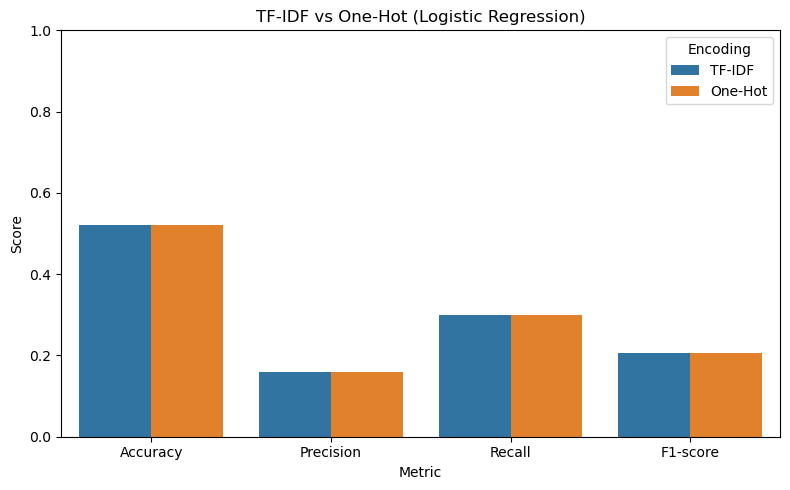

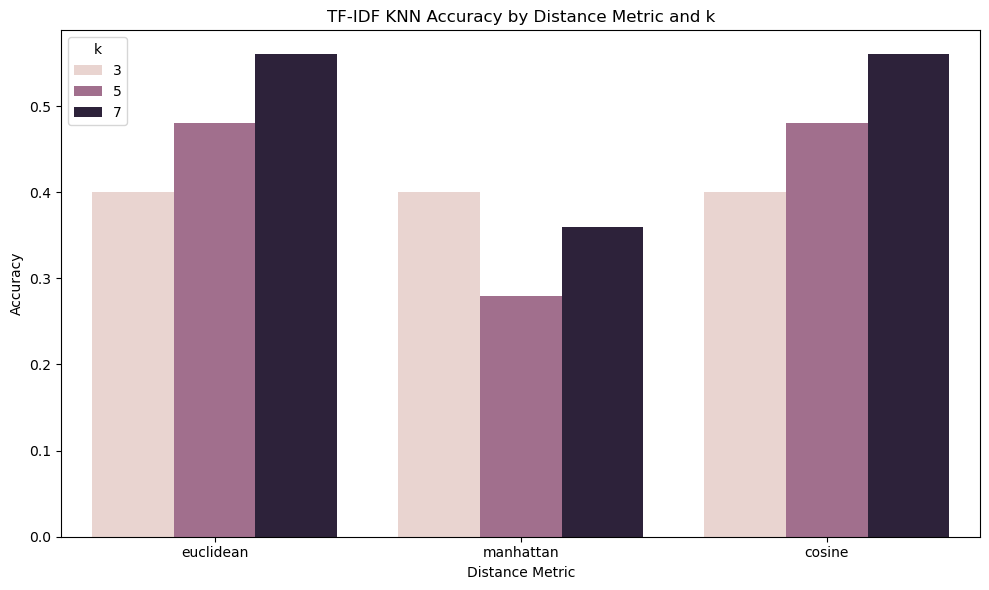

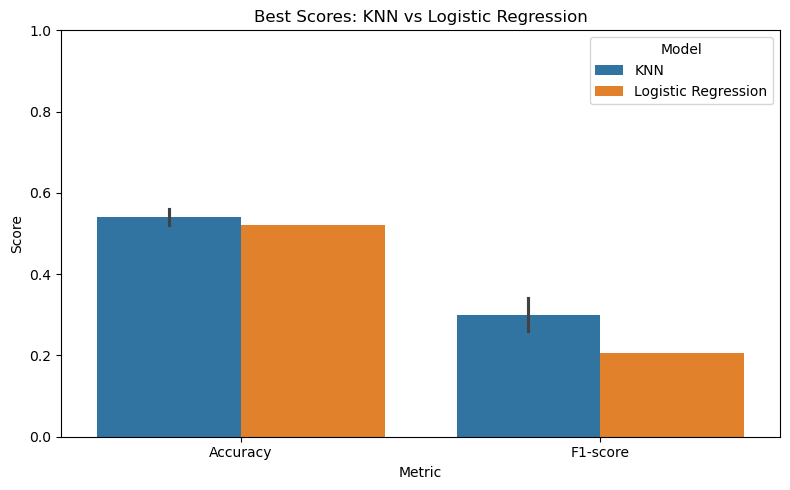

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. TF-IDF vs One-Hot (LogReg only)
def plot_encoding_comparison(lr_df):
    plt.figure(figsize=(8, 5))
    sns.barplot(data=lr_df.melt(id_vars=["Encoding", "Model"], value_vars=["Accuracy", "Precision", "Recall", "F1-score"]),
                x="variable", y="value", hue="Encoding")
    plt.title("TF-IDF vs One-Hot (Logistic Regression)")
    plt.ylabel("Score")
    plt.xlabel("Metric")
    plt.ylim(0, 1)
    plt.legend(title="Encoding")
    plt.tight_layout()
    plt.show()

# 2. KNN Distance Metric Comparison (TF-IDF only)
def plot_knn_distances(knn_df):
    tfidf_knn = knn_df[knn_df["Encoding"] == "TF-IDF"]
    plt.figure(figsize=(10, 6))
    sns.barplot(data=tfidf_knn, x="Distance Metric", y="Accuracy", hue="k")
    plt.title("TF-IDF KNN Accuracy by Distance Metric and k")
    plt.ylabel("Accuracy")
    plt.tight_layout()
    plt.show()

# 3. KNN vs Logistic Regression (best scores)
def plot_model_comparison(knn_df, lr_df):
    best_knn = knn_df.groupby("Encoding")[["Accuracy", "F1-score"]].max().reset_index()
    best_lr = lr_df[["Encoding", "Accuracy", "F1-score"]].copy()
    best_lr["Model"] = "Logistic Regression"
    best_knn["Model"] = "KNN"
    combined = pd.concat([best_knn, best_lr], ignore_index=True)

    plt.figure(figsize=(8, 5))
    sns.barplot(data=combined.melt(id_vars=["Encoding", "Model"], value_vars=["Accuracy", "F1-score"]),
                x="variable", y="value", hue="Model")
    plt.title("Best Scores: KNN vs Logistic Regression")
    plt.ylabel("Score")
    plt.xlabel("Metric")
    plt.ylim(0, 1)
    plt.legend(title="Model")
    plt.tight_layout()
    plt.show()

# Run all plots
plot_encoding_comparison(lr_results_df)
plot_knn_distances(results_df)
plot_model_comparison(results_df, lr_results_df)
